# W207.6 Final Project - Predicting Cancer Type from Tumor Mutations
## Notebook 2 - Feature Engineering
### Tony Di Sera, Vijay Singh, Rajiv Nair, Jeremey Fraenkel


## Initialization

In [0]:
import pandas as pd
import urllib.request
import numpy as np
import glob
import os
import warnings
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

plt.rcParams.update({'figure.max_open_warning': 0})
InteractiveShell.ast_node_interactivity = "all"

# Establish the colors for each cancer type
label_colors = []
cm = plt.get_cmap('tab20b')
for i in range(20):
    label_colors.append(cm(i))
cm = plt.get_cmap('tab20c')
for i in range(13):
    label_colors.append(cm(i))

In [0]:
#from google.colab import drive
#drive.mount('/content/drive/')


In [2]:
#cd /content/drive/My Drive/berkeley/W207 machine learning/Final Project/w207_6_sum19_g5_final_project/final_notebooks

/content/drive/My Drive/berkeley/W207 machine learning/Final Project/w207_6_sum19_g5_final_project/final_notebooks


In [0]:
# create the directory where the downloaded directory is stored
data_dir = "./data"
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
# create the directory where the metrics are stored
metrics_dir = "./metrics"
if not os.path.isdir(metrics_dir):
    os.makedirs(metrics_dir)
    
# create the raw where the source data is stored
raw_dir = "./raw"
if not os.path.isdir(raw_dir):
    os.makedirs(raw_dir)    

In [4]:
# This downloads a dictionary file
dictionary_filename = "./raw/tcga_dictionaries.txt"
if os.path.isfile(dictionary_filename):
    print("Skipping download, as file %s is present" %(dictionary_filename))
else:
    print('Downloading dictionary file...')
    url = 'https://w207-final-project.s3.amazonaws.com/raw/tcga_dictionaries.txt'  
    urllib.request.urlretrieve(url, dictionary_filename)  
print("done.")


# This loads the data dictionary to will convert
# the tumor_sample_barcode into a cancer_type
# and provide full names for the cancer types
tcga_dict = open("./raw/tcga_dictionaries.txt","r")
dict_name_index = 0 #Set dictionary index counter to 0
for line in tcga_dict:
    if line.startswith("#"): #If line starts with #, the next line will be a known dictionary
        dict_name_index += 1
    elif dict_name_index == 4:
        tissue_source_site = eval(line)            
    elif dict_name_index == 5:
        code_to_disease = eval(line)
    elif dict_name_index == 6:
        disease_to_code = eval(line)

Skipping download, as file ./raw/tcga_dictionaries.txt is present
done.


## EDA and Feature Selection



Here, we open the data we put together in the previous notebook. For the initial analysis, we look at $cancer\_type$, $patient\_barcode$, $gene$ and $gene\_type$.

### Load the mutations train and test datasets.

In [5]:
print('Loading data ...')
mutations = {}
mutations['train'] = pd.read_csv("./data/somatic_mutations_train.csv", 
                             usecols=['cancer_type', 'patient_barcode', 'gene', 'gene_type'])
mutations['test']  = pd.read_csv("./data/somatic_mutations_test.csv", 
                             usecols=['cancer_type', 'patient_barcode', 'gene', 'gene_type'])
print("done.")
print("Mutations training data count:", mutations['train']['patient_barcode'].count())
print("Mutations test data count:    ", mutations['test']['patient_barcode'].count())

Loading data ...
done.
Mutations training data count: 2820587
Mutations test data count:     773193


### Show distribution of genes across patient tumors

Number of genes across all patient tumors: 21145





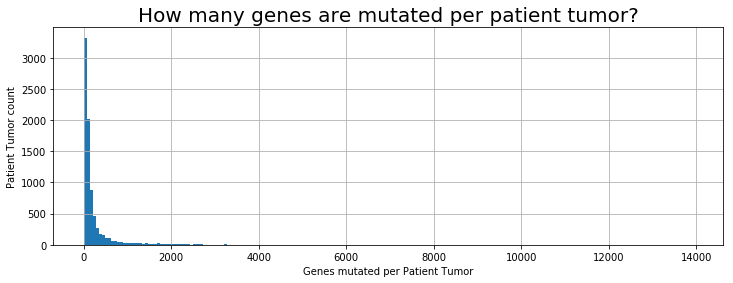

Number of genes per patient tumor
  min:     1
  max:     13921
  mean:    273
  median:  90




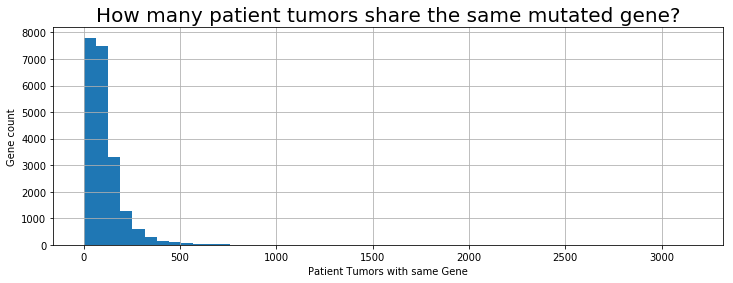

Number of patient tumors with same mutated gene
  min:     1
  max:     3160
  mean:    105
  median:  84




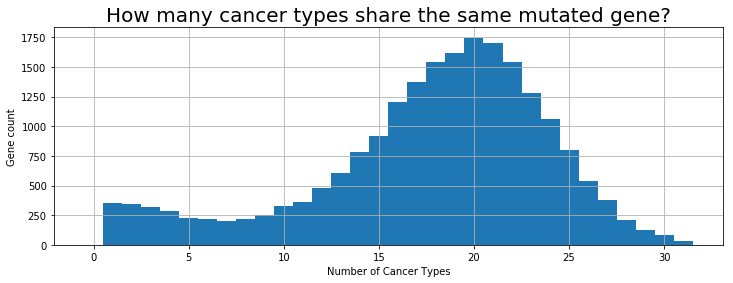


Number of cancer types with same mutated gene
  min, max:  1 , 33
  mean    : 17
  median  : 19


In [19]:
print("Number of genes across all patient tumors:", mutations['train'].gene.nunique())
print("\n\n")

#
# Show how many genes are mutation in a patient tumor
#
group1         = mutations['train'].groupby(['patient_barcode'])['gene'].nunique().reset_index(name='count')
group1.columns = ['patient', 'gene_count']
ax = group1['gene_count'].hist(bins=200, figsize=(12,4))
_ = ax.set_xlabel("Genes mutated per Patient Tumor")
_ = ax.set_ylabel("Patient Tumor count")
_ = ax.set_title("How many genes are mutated per patient tumor?", fontsize=20)
plt.show()
print('Number of genes per patient tumor')
print("  min:    ", int(group1['gene_count'].min()))
print("  max:    ", int(group1['gene_count'].max()))
print("  mean:   ", int(group1['gene_count'].mean()))
print("  median: ", int(group1['gene_count'].median()))
print("\n")

#
# Show now many tumors contain the same gene
#
group2         = mutations['train'].groupby(['gene'])['patient_barcode'].nunique().reset_index(name='count')
group2.columns = ['gene', 'patient_count']
ax = group2['patient_count'].hist(bins=50,  figsize=(12,4))
_ = ax.set_xlabel("Patient Tumors with same Gene")
_ = ax.set_ylabel("Gene count")
_ = ax.set_title("How many patient tumors share the same mutated gene?", fontsize=20)
plt.show()
print('Number of patient tumors with same mutated gene')
print("  min:    ", int(group2['patient_count'].min()))
print("  max:    ", int(group2['patient_count'].max()))
print("  mean:   ", int(group2['patient_count'].mean()))
print("  median: ", int(group2['patient_count'].median()))
print("\n")


#
# Show now many cancer types contain the same gene
#
gene_cc_count         = mutations['train'].groupby(['gene'])['cancer_type'].nunique().reset_index(name='count')
gene_cc_count.columns = ['gene', 'cancer_type_count']
gene_cc_count         = gene_cc_count.sort_values(['cancer_type_count', 'gene'], ascending=[0,1])
bins = np.arange(33) - 0.5
ax = gene_cc_count['cancer_type_count'].hist(bins=bins, range=[0,32], figsize=(12,4))
_ = ax.set_xlabel("Number of Cancer Types")
_ = ax.set_ylabel("Gene count")
_ = ax.set_title("How many cancer types share the same mutated gene?", fontsize=20)
plt.show()
print('\nNumber of cancer types with same mutated gene')
print("  min, max: ", int(gene_cc_count['cancer_type_count'].min()), ',', int(gene_cc_count['cancer_type_count'].max()))
print("  mean    :", int(gene_cc_count['cancer_type_count'].mean()))
print("  median  :", int(gene_cc_count['cancer_type_count'].median()))

From the histogram above, it is clear that even through we have a large number of genes, only a small number of them are turned on in the patient tumor data that we have. This is the classic problem of a large feature space with a much smaller number of samples. Hence we will need to perform a dimensionality reduction technique such as PCA here.


Number of cancer types: 33
Number of patients    : 8179




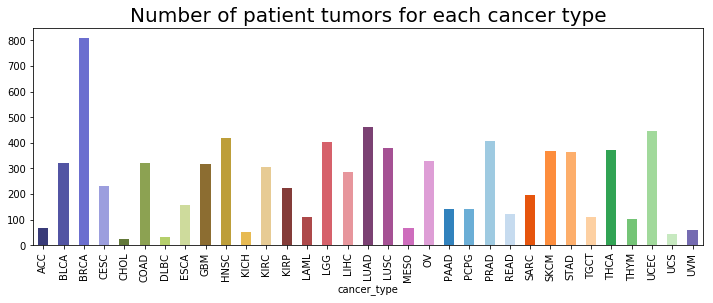

In [13]:
# Print out the number of cancer types that are present in the 
# mutations dataset
cancer_types = mutations['train'].cancer_type.unique()
print("\nNumber of cancer types:", len(cancer_types))

# Get number of cases per cancer type
group_patients_by_cancer = mutations['train'].groupby(['cancer_type'])['patient_barcode'].nunique()
print("Number of patients    :", group_patients_by_cancer.sum())
print("\n")
ax = group_patients_by_cancer.plot.bar(figsize=(12,4), color=label_colors)
_ = ax.set_title("Number of patient tumors for each cancer type", fontsize=20)

The above chart shows that there are some cancers, such as BRCA and LUAD that have a large representation in our dataset, but other such as DBLC and UCS that are present in much smaller numbers. This will present a challenge for our classifier. Specifically, we want our classifier to be able to classify each of the 32 types of cancers with high precision, but the model should also be able to identify the cancers that don't have a proportionate representation in our data set. It could be that these are cancers are rare, or perhaps they are simply rare in our dataset. **Note:** add more details about the cancers that are abundant as well as rare in this dataset.

Number of genes in each cancer type
  min:    1427
  max:    20797
  mean:   11363
  median: 12521




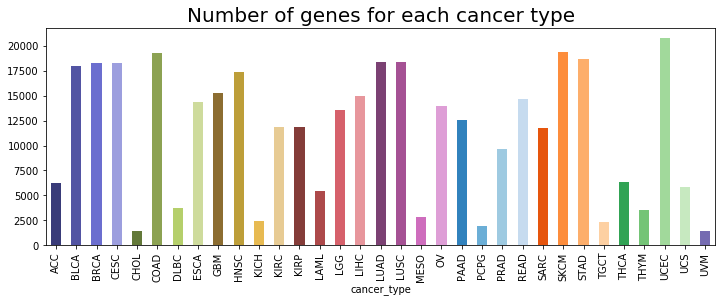

In [12]:
# Get the unique genes per cancer type
group_genes_by_cancer = mutations['train'].groupby(['cancer_type'])['gene'].nunique();

print("Number of genes in each cancer type")
print("  min:   ", int(np.round(group_genes_by_cancer.min())))
print("  max:   ", int(np.round(group_genes_by_cancer.max())))
print("  mean:  ", int(np.round(group_genes_by_cancer.mean())))
print("  median:", int(np.round(group_genes_by_cancer.median())))
print("\n")


ax = group_genes_by_cancer.plot.bar(figsize=(12,4), color=label_colors)
_ = ax.set_title("Number of genes for each cancer type", fontsize=20)

The above bar chart gives us an idea of how many genes (features for us) are _on_ for each of the cancer types. Cross referencing this chart with the previous one, we see that for some cancers such as DLBC and UCS we have a fair number of active features, even though the number of cases of such cancers are low. We should be able to person isolated (one-vs-rest) analysis for these cases. However, for other cancers, such as KICH (Kidney Chromophobe) and UVM (Uveal Melanoma) we have both a low occurance rate, and a low number of active features. This second category of cancers will need to be handled with care.

## Create different feature sets

From an initial analysis of our data, we can see that we have a large number of features (binary encoded gene mutations), and the number of features is greater than the number of samples that we have. Even before we try any dimentionality reduction technique such as PCA, we can use other tools to reduce the number of features. One such method is the scikit utility **SelectKBest**. This utility routine can apply the **Chi-Square** test to select the specified number of best features. Another method is to use a LogisticRegression Classifier with L1 regularization and an appropriate C value. This will drive down the coefficients of non-important features to 0, which can then be removed. We try multiple such methods below.

In [0]:
#
# Create feature matrix each row is a patient tumor; each column is a gene
#
def create_patient_x_gene_matrix(mutations, feature_genes, description, save=True, add_patient_data=None):
    lmap = pd.Series(mutations.cancer_type.values,index=mutations.patient_barcode).to_dict()
    cases_df = mutations.reset_index()

    cases_df = pd.pivot_table(cases_df, index="patient_barcode", columns='gene', values = 'index', aggfunc="count")
    
    # this block below changes the columns to a 1/0 depending on whether the gene exists.
    for col in cases_df.columns:
        cases_df[col] = np.where(cases_df[col]>0., 1., 0.)

    cases_df = pd.DataFrame(cases_df.to_records())

    # add missing columns
    missing_cols = set(feature_genes) - set(cases_df.columns)
    for col in missing_cols:
        cases_df[col] = 0.
    cases_df['cancer_type'] = cases_df["patient_barcode"].map(lmap)
    cases_df = cases_df.rename(columns={"patient_barcode": "case_id"})
    # order columns correctly
    cases_df = cases_df[['case_id', 'cancer_type'] + list(feature_genes)]
    print("  ", cases_df.shape)
    #merge patient data if provided
    if add_patient_data is not None:
      cases_df = pd.merge(cases_df, add_patient_data, left_on='case_id', right_on='bcr_patient_barcode',how='left')
      cases_df = cases_df.drop(columns=['bcr_patient_barcode'])

    cases_df = cases_df.fillna(0.0)
    # Write out transformed data to csv
    if save:
        fileName = "./data/" + description + ".csv"
        print("  writing", fileName, "...")
        cases_df.to_csv(fileName)
        print("  done.")
    
    return cases_df

#
# Create a feature matrix based on most frequent genes in each cancer type
#
def create_feature_matrix(mutations_train, mutations_test, top_n_gene_count, save, description):
    print("Formatting gene matrix with top ", top_n_gene_count, "genes from each cancer type")
    
    # Now try to find the most common genes per cancer type and
    # merge these together to come up with a master list
    cancer_gene_count = mutations_train.groupby(['cancer_type', 'gene'])['patient_barcode'].nunique().reset_index(name='count')
    cancer_gene_count.columns = ['cancer_type', 'gene', 'patient_count']

    # Now create a large matrix, row is the gene, column for each cancer type
    df = pd.DataFrame(cancer_gene_count, columns=['cancer_type', 'gene', 'patient_count'])
    gene_cancer_matrix = pd.pivot_table(df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)

    # Now find the top n genes for each cancer type
    top_genes = []
    idx = 0

    plt.rcParams["figure.figsize"] = (20,20)
    for cancer_type in gene_cancer_matrix.columns:
        sorted_genes = gene_cancer_matrix[cancer_type].sort_values(ascending=False)
        top_rows = sorted_genes[sorted_genes > 0].head(top_n_gene_count)
        for gene, patient_count in top_rows.items():
            top_genes.append(list([cancer_type, gene, patient_count]))

    # Turn this back into a matrix, row is gene, column for each cancer type
    top_df = pd.DataFrame(top_genes, columns=['cancer_type', 'gene', 'patient_count'])
    top_gene_cancer_matrix = pd.pivot_table(top_df, values='patient_count', index=['gene'],
                         columns=['cancer_type'], aggfunc=np.sum, fill_value=0)
    print("  number of genes:", top_gene_cancer_matrix.shape[0])
   
    feature_genes = top_gene_cancer_matrix.index
    create_patient_x_gene_matrix(mutations_train, feature_genes, description + ".train", save)
    create_patient_x_gene_matrix(mutations_test,  feature_genes, description + ".test", save)
    
#
# Create a feature matrix for all genes in tumor mutations
#
def create_all_feature_matrix(mutations_train, mutations_test, save, description, patient_data=None):
    print("Formatting gene matrix with for all features")
    #
    # Create feature matrix, each row is patient, columns are genes
    #
    feature_genes = pd.Series(mutations_train.gene.unique())
    feature_matrix_train = create_patient_x_gene_matrix(mutations_train, feature_genes, description + ".train", save, patient_data)
    feature_matrix_test  = create_patient_x_gene_matrix(mutations_test,  feature_genes, description + ".test", save, patient_data)
    return feature_matrix_train, feature_matrix_test
  
#
# Run KBestFit to determine most discriminatory genes
#
def get_best_fit_features(feature_matrix, n_features):
    #apply SelectKBest class to extract top n best features
    bestfeatures = SelectKBest(score_func=chi2, k=n_features)
    
    data = feature_matrix.loc[:, (feature_matrix.columns != 'cancer_type') & (feature_matrix.columns != 'case_id')]
    labels_string = feature_matrix['cancer_type']
    
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels_string)
    
    fit = bestfeatures.fit(data,labels)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data.columns)
    
    #concat two dataframes for better visualization 
    scores_df = pd.concat([dfcolumns,dfscores], axis=1)
    scores_df.columns = ['gene', 'score']
    sorted_scores = scores_df.sort_values(by=['score', 'gene'], ascending=[0,1])
    return sorted_scores.gene.values
 
#
# Create a feature matrix based on genes ranked highest using KBestFit
#
def create_best_fit_feature_matrix(feature_matrix_train, feature_matrix_test,  
                               save, description, k_best_fits):
    #
    #  Try BestFit (chi squared test) to find most
    #  important genes
    #
    print("Running KBestFit")
    best_genes_ranked  = get_best_fit_features(feature_matrix_train, 8000)
    
    print("  done.")

    for k_best in k_best_fits:
        print("Creating gene matrix with best fit for", k_best, "features")
        best_genes = best_genes_ranked[:k_best]
        print(len(best_genes))
      
        cancer_type = feature_matrix_train['cancer_type']
        case_id     = feature_matrix_train['case_id']
        data_train  = feature_matrix_train.loc[:, feature_matrix_train.columns.isin(best_genes)]
        final_feature_matrix_train = pd.concat([case_id, cancer_type, data_train], axis=1)

        cancer_type = feature_matrix_test['cancer_type']
        case_id     = feature_matrix_test['case_id']
        data_test   = feature_matrix_test.loc[:, feature_matrix_test.columns.isin(best_genes)]
        final_feature_matrix_test = pd.concat([case_id, cancer_type, data_test], axis=1)

        if save:
            fileName = "./data/" + description  + "_" + str(k_best) + ".train.csv"
            print("  writing", fileName, "...")
            print(" ", final_feature_matrix_train.shape)
            final_feature_matrix_train.to_csv(fileName)
            print("  done.")        

            fileName = "./data/" + description  + "_" + str(k_best) + ".test.csv"
            print("  writing", fileName, "...")
            print(" ", final_feature_matrix_test.shape)
            final_feature_matrix_test.to_csv(fileName)
            print("  done.") 

#
# Create a different feature matrix based on changing L1 regularization strength
#
def create_l1_feature_matrix(train_features, test_features, label_encoder, description, save):
    
    train_first_cols    = train_features[train_features.columns[:2]]
    train_data          = train_features[train_features.columns[3:]]
    train_labels        = label_encoder.fit_transform(train_features.cancer_type)

    test_first_cols    = test_features[test_features.columns[:2]]
    test_data          = test_features[test_features.columns[3:]]
    test_labels        = label_encoder.fit_transform(test_features.cancer_type)

    params = {'C':  [100, 10, 1, .5, .25, .1, .05, .025 ]}
    
    for c_param in reversed(params['C']):
        # Keep this random seed here to make comparison easier.
        np.random.seed(0)

        #
        # Perform Logistic Regression on different C values
        # using L1 regularization
        #
        l1 = LogisticRegression(penalty='l1', tol=.01, 
                            solver="liblinear", multi_class="ovr",
                            max_iter=500, C=c_param)
        # Fit model
        l1.fit(train_data, train_labels) 


        # Get the features with non-zero coefficients.  We will use
        # this list to reduce the features 
        non_zero_sums = np.where(np.sum(l1.coef_, axis=0) != 0)
        names = np.array(list(train_data.columns))
        non_zero_genes = names[non_zero_sums] 


        #
        # Reduce feature size, only keeping features with non-zero weights 
        # found using l1 regularization
        #
        trimmed_train_data = train_data[non_zero_genes]
        trimmed_test_data  = test_data[non_zero_genes]
        
        final_features_train = pd.concat([train_first_cols, trimmed_train_data], axis=1)
        final_features_test =  pd.concat([test_first_cols, trimmed_test_data], axis=1)
        
        if save:
            fileName = "./data/" + description + "_c" + str(c_param) + ".train.csv"
            print("  writing", fileName, "...")
            print(" ", final_features_train.shape)
            final_features_train.to_csv(fileName)
            print("  done.")        

            fileName = "./data/" + description + "_c" + str(c_param) + ".test.csv"
            print("  writing", fileName, "...")
            print(" ", final_features_test.shape)
            final_features_test.to_csv(fileName)
            print("  done.")        
            
#
# Create a feature matrix using recursive feature elimination
#
def create_rfe_feature_matrix(train_features, test_features, label_encoder, 
                              classifier, n_features, n_step,
                              description, save):

    
    train_first_cols    = train_features[train_features.columns[:2]]
    train_data          = train_features[train_features.columns[3:]]
    train_labels        = label_encoder.fit_transform(train_features.cancer_type)

    test_first_cols    = test_features[test_features.columns[:2]]
    test_data          = test_features[test_features.columns[3:]]
    test_labels        = label_encoder.fit_transform(test_features.cancer_type)
    

    rfe = RFE(estimator=classifier, n_features_to_select=n_features, step=n_step, verbose=3)
    rfe.fit(train_data, train_labels)
    
    trimmed_train_data = train_data[train_data.columns[rfe.support_]]
    trimmed_test_data  = test_data[test_data.columns[rfe.support_]]
    
    final_features_train = pd.concat([train_first_cols, trimmed_train_data], axis=1)
    final_features_test =  pd.concat([test_first_cols, trimmed_test_data], axis=1)
    

    if save:
        fileName = "./data/" + description +  ".train.csv"
        print("  writing", fileName, "...")
        print(" ", final_features_train.shape)
        final_features_train.to_csv(fileName)
        print("  done.")        

        fileName = "./data/"+ description + ".test.csv"
        print("  writing", fileName, "...")
        print(" ", final_features_test.shape)
        final_features_test.to_csv(fileName)
        print("  done.")        
    
    return final_features_train, final_features_test

### All genes

Create a feature matrix,  Feature matrix will have one row per patient tumor, 
column for every gene encountered in training data set.

In [0]:
all_train_file = './data/features_all.train.csv'
all_test_file = './data/features_all.test.csv'

if os.path.isfile(all_train_file) and os.path.isfile(all_test_file):
    print("Skipping generation, loading files %s and %s..." %(all_train_file, all_test_file))
    feature_matrix_train = pd.read_csv(all_train_file)
    feature_matrix_test  = pd.read_csv(all_test_file)
    print(" .done")
else:
    feature_matrix_train, feature_matrix_test = create_all_feature_matrix(mutations['train'], 
                                                    mutations['test'], True, 'features_all')



Formatting gene matrix with for all features
   (8179, 21147)
  writing ./data/features_all.train.csv ...
  done.
   (2045, 21147)
  writing ./data/features_all.test.csv ...
  done.


### All genes with Patient data

In [0]:
all_train_file = './data/features_all_patient.train.csv'
all_test_file = './data/features_all_patient.test.csv'

patient_data = pd.read_csv('./data/patient_clinical_data.txt', usecols=['bcr_patient_barcode', 'gender'],
                           delimiter="\t",encoding='iso-8859-1')
patient_data = patient_data[['bcr_patient_barcode', 'gender']]


ge = preprocessing.LabelEncoder()
re = preprocessing.LabelEncoder()

patient_data = patient_data[['bcr_patient_barcode', 'gender']]
patient_data.gender = ge.fit_transform(patient_data.gender)

if os.path.isfile(all_train_file) and os.path.isfile(all_test_file):
    print("Skipping generation, files %s and %s are present." %(all_train_file, all_test_file))
    feature_matrix_train_patient, feature_matrix_test_patient = create_all_feature_matrix(mutations['train'], 
                                                    mutations['test'], False, 'features_all_patient', patient_data)
else:
    feature_matrix_train_patient, feature_matrix_test_patient = create_all_feature_matrix(mutations['train'], 
                                                    mutations['test'], True, 'features_all_patient', patient_data)

print(" done.")

Formatting gene matrix with for all features
   (8179, 21147)
  writing ./data/features_all_patient.train.csv ...
  done.
   (2045, 21147)
  writing ./data/features_all_patient.test.csv ...
  done.
 done.


### Top n genes most frequent in each cancer type

Create a feature matrix, getting the top n genes that are most frequent
per label (cancer type).  Merge these genes and create a feature matrix,
one row per patient tumor, column for each merged gene

In [0]:
create_feature_matrix(mutations['train'], mutations['test'], 100, True, 'features_top_100_genes')

Formatting gene matrix with top  100 genes from each cancer type
  number of genes: 1202
   (8179, 1204)
  writing ./data/features_top_100_genes.train.csv ...
  done.
   (2045, 1204)
  writing ./data/features_top_100_genes.test.csv ...
  done.


### KBestFit 

Create a feature matrix, using sklearn BestFit to find top 100, 800, 4000, 8000 genes. Feature matrix will have one row per patient tumor, column for each 'bestfit' gene



In [0]:
create_best_fit_feature_matrix(feature_matrix_train, feature_matrix_test, True, 
                          'features_bestfit', [100, 800, 4000, 8000])


Running KBestFit
  done.
Creating gene matrix with best fit for 100 features
100
  writing ./data/features_bestfit_100.train.csv ...
  (8179, 102)
  done.
  writing ./data/features_bestfit_100.test.csv ...
  (2045, 102)
  done.
Creating gene matrix with best fit for 800 features
800
  writing ./data/features_bestfit_800.train.csv ...
  (8179, 802)
  done.
  writing ./data/features_bestfit_800.test.csv ...
  (2045, 802)
  done.
Creating gene matrix with best fit for 4000 features
4000
  writing ./data/features_bestfit_4000.train.csv ...
  (8179, 4002)
  done.
  writing ./data/features_bestfit_4000.test.csv ...
  (2045, 4002)
  done.
Creating gene matrix with best fit for 8000 features
8000
  writing ./data/features_bestfit_8000.train.csv ...
  (8179, 8002)
  done.
  writing ./data/features_bestfit_8000.test.csv ...
  (2045, 8002)
  done.


### Logistic Regression (L1)

Trim the features using Logistic Regression, L1 regularization

In [0]:
label_encoder            = preprocessing.LabelEncoder()
create_l1_feature_matrix(feature_matrix_train, feature_matrix_test, label_encoder,
           'features_l1reg', True)

  writing ./data/features_l1reg_c0.025.train.csv ...
  (8179, 57)
  done.
  writing ./data/features_l1reg_c0.025.test.csv ...
  (2045, 57)
  done.
  writing ./data/features_l1reg_c0.05.train.csv ...
  (8179, 185)
  done.
  writing ./data/features_l1reg_c0.05.test.csv ...
  (2045, 185)
  done.
  writing ./data/features_l1reg_c0.1.train.csv ...
  (8179, 544)
  done.
  writing ./data/features_l1reg_c0.1.test.csv ...
  (2045, 544)
  done.
  writing ./data/features_l1reg_c0.25.train.csv ...
  (8179, 2271)
  done.
  writing ./data/features_l1reg_c0.25.test.csv ...
  (2045, 2271)
  done.
  writing ./data/features_l1reg_c0.5.train.csv ...
  (8179, 4761)
  done.
  writing ./data/features_l1reg_c0.5.test.csv ...
  (2045, 4761)
  done.
  writing ./data/features_l1reg_c1.train.csv ...
  (8179, 7581)
  done.
  writing ./data/features_l1reg_c1.test.csv ...
  (2045, 7581)
  done.
  writing ./data/features_l1reg_c10.train.csv ...
  (8179, 14831)
  done.
  writing ./data/features_l1reg_c10.test.csv ...

### RFE

In [0]:
label_encoder            = preprocessing.LabelEncoder()

lr = LogisticRegression(penalty='l1', C=0.1)

n_features = [100, 800, 4000, 8000]
n_step = .20

label_encoder            = preprocessing.LabelEncoder()

for n_feature in n_features:
    
    _,_ = create_rfe_feature_matrix(feature_matrix_train, 
                         feature_matrix_test,
                         label_encoder,
                         lr, n_feature, n_step,
                         'features_rfe_'  + str(n_feature),
                         True)


Fitting estimator with 21144 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 16916 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 12688 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 8460 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 4232 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


  writing ./data/features_rfe_100.train.csv ...
  (8179, 102)
  done.
  writing ./data/features_rfe_100.test.csv ...
  (2045, 102)
  done.
Fitting estimator with 21144 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 16916 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 12688 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 8460 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 4232 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


  writing ./data/features_rfe_800.train.csv ...
  (8179, 802)
  done.
  writing ./data/features_rfe_800.test.csv ...
  (2045, 802)
  done.
Fitting estimator with 21144 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 16916 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 12688 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 8460 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 4232 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


  writing ./data/features_rfe_4000.train.csv ...
  (8179, 4002)
  done.
  writing ./data/features_rfe_4000.test.csv ...
  (2045, 4002)
  done.
Fitting estimator with 21144 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 16916 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 12688 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting estimator with 8460 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


  writing ./data/features_rfe_8000.train.csv ...
  (8179, 8002)
  done.
  writing ./data/features_rfe_8000.test.csv ...
  (2045, 8002)
  done.


### PCA for dimensionality reduction

In [0]:
pca = PCA(0.99)
all_features_train = feature_matrix_train.drop(columns=['case_id', 'cancer_type'])
pca.fit(all_features_train)
train_PCA = pca.transform(all_features_train)
all_features_test = feature_matrix_test.drop(columns=['case_id', 'cancer_type'])
test_PCA = pca.transform(all_features_test)


PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
print("Number of features that explain 99% of the variance: ", train_PCA.shape[1])

Number of features that explain 99% of the variance:  6060


In [0]:
train_PCA_df = pd.DataFrame(train_PCA)
train_PCA_df['case_id'] = feature_matrix_train['case_id']
train_PCA_df['cancer_type'] = feature_matrix_train['cancer_type']

test_PCA_df = pd.DataFrame(test_PCA)
test_PCA_df['case_id'] = feature_matrix_test['case_id']
test_PCA_df['cancer_type'] = feature_matrix_test['cancer_type']

#reorder columns and write out
for df, f_name in zip( (train_PCA_df, test_PCA_df), 
                      ('./data/features_after_pca.train.csv', './data/features_after_pca.test.csv') ):
    cols = df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df = df[cols]
    df.to_csv(f_name)

## Dimensionality reduction using random forest

In [0]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=50)

labels = feature_matrix_train_patient['cancer_type']

all_features_train = feature_matrix_train_patient.drop(columns=['case_id', 'cancer_type'])
all_features_test = feature_matrix_test_patient.drop(columns=['case_id', 'cancer_type'])

feats  = list(all_features_train.columns)
sel = SelectFromModel(rf)
_ = sel.fit(all_features_train, labels)
sel_feats =  sel.get_support(indices=True)
sel_feats = ['case_id', 'cancer_type']+[feats[i] for i in sel_feats]

print("Size of reduced list of features selected by Random Forest = ", len(sel_feats))
for df, f_name in zip( (feature_matrix_train_patient, feature_matrix_test_patient), 
                      ('./data/features_after_rf.train.csv', './data/features_after_rf.test.csv') ):
    df = df[sel_feats]
    df.to_csv(f_name)
print(" .done")

Size of reduced list of features selected by Random Forest =  6075
 .done
